### Reference
* http://users.cecs.anu.edu.au/~u5098633/papers/www15.pdf
* https://grouplens.org/datasets/movielens/1m/
* https://vitobellini.github.io/posts/2018/01/03/how-to-build-a-recommender-system-in-tensorflow.html
* https://github.com/npow/AutoRec

In [1]:
import random
import numpy as np
import pandas as pd
import tensorflow as tf

print('version info:')
print('Numpy\t', np.__version__)
print('Pandas\t', pd.__version__)
print('TF\t', tf.__version__)

version info:
Numpy	 1.19.5
Pandas	 1.0.5
TF	 2.4.0


In [2]:
BATCH_SIZE = 256
WEIGHT_DECAY = 5e-4

### [Option] download MovieLens 1M dataset

In [3]:
import os
import wget
import zipfile

dirPath = '../dataset'
zipFilePath = os.path.join(dirPath, 'ml-1m.zip')
remoteRrl = 'https://files.grouplens.org/datasets/movielens/ml-1m.zip'

if not os.path.exists(dirPath):
    os.makedirs(dirPath)
    
# download
wget.download(remoteRrl, zipFilePath)

# unzip files
with zipfile.ZipFile(zipFilePath, 'r') as zipRef:
    zipRef.extractall(dirPath)

100% [..........................................................................] 5917549 / 5917549

## load dataset

In [4]:
df = pd.read_csv('../dataset/ml-1m/ratings.dat', sep='::', engine='python', names=['UserID', 'MovieID', 'Rating', 'Timestamp'], header=None)
df = df.drop('Timestamp', axis=1)

numOfUsers = df.UserID.nunique()
numOfItems = df.MovieID.nunique()

In [5]:
df.head()

,UserID,MovieID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [6]:
# Normalize rating in [0, 1]
ratings = df.Rating.values.astype(np.float)
scaledRatings = (ratings - min(ratings)) / (max(ratings) - min(ratings))
df.Rating = pd.DataFrame(scaledRatings)

In [7]:
df.head()

,UserID,MovieID,Rating
0,1,1193,1.00
1,1,661,0.50
2,1,914,0.50
3,1,3408,0.75
4,1,2355,1.00


In [8]:
# user-item rating matrix
## U-AutoRec (users-based)
userItemRatingMatrix = df.pivot(index='UserID', columns='MovieID', values='Rating')
## I-AutoRec (items-based)
# userItemRatingMatrix = df.pivot(index='MovieID', columns='UserID', values='Rating')
userItemRatingMatrix.fillna(-1, inplace=True)

In [9]:
userItemRatingMatrix

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.0,-1.0,-1.0,-1.00,-1.0,-1.00,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,-1.0,-1.0,-1.0,-1.00,-1.0,-1.00,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,-1.0,-1.0,-1.0,-1.00,-1.0,-1.00,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,-1.0,-1.0,-1.0,-1.00,-1.0,-1.00,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
5,-1.0,-1.0,-1.0,-1.00,-1.0,0.25,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,-1.0,-1.0,-1.0,0.25,-1.0,0.50,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
6037,-1.0,-1.0,-1.0,-1.00,-1.0,-1.00,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
6038,-1.0,-1.0,-1.0,-1.00,-1.0,-1.00,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [10]:
# create tf.dataset

def getDataset(userItemRatingMatrix):
    userItemRatingMatrix_np = userItemRatingMatrix.to_numpy(dtype=np.float32)
    random.shuffle(userItemRatingMatrix_np)
    
    # [train : valid : test] = [0.7 : 0.15 : 0.15]
    numOfTrainSet = int(numOfUsers * 0.7)
    numOfValidSet = int(numOfUsers * 0.15)
    numOfTestSet = numOfUsers - numOfTrainSet - numOfValidSet
    
    trainSet_np = userItemRatingMatrix_np[0:numOfTrainSet]
    validSet_np = userItemRatingMatrix_np[numOfTrainSet:numOfTrainSet+numOfValidSet]
    testSet_np  = userItemRatingMatrix_np[numOfTrainSet+numOfValidSet:]
    
    trainSet = tf.data.Dataset.from_tensor_slices(trainSet_np)
    validSet = tf.data.Dataset.from_tensor_slices(validSet_np)
    testSet = tf.data.Dataset.from_tensor_slices(testSet_np)
    
    trainSet = trainSet.shuffle(buffer_size=BATCH_SIZE*8).batch(BATCH_SIZE)
    validSet = validSet.batch(BATCH_SIZE)
    testSet = testSet.batch(BATCH_SIZE)
    
    return trainSet, validSet, testSet

trainSet, validSet, testSet = getDataset(userItemRatingMatrix)

## build model

In [11]:
# build model
## tf.keras.Dense: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense

regularizer = tf.keras.regularizers.L2(WEIGHT_DECAY)

def getEncoder(numOfInput, numOfHidden1, numOfHidden2):
    x = tf.keras.Input(shape=(numOfInput,))
    out = tf.keras.layers.Dense(units=numOfHidden1, activation='sigmoid', kernel_regularizer=regularizer) (x)
    out = tf.keras.layers.Dense(units=numOfHidden2, activation='sigmoid', kernel_regularizer=regularizer) (out)
    return tf.keras.Model(inputs=[x], outputs=[out])

def getDecoder(numOfInput, numOfHidden1, numOfHidden2):
    x = tf.keras.Input(shape=(numOfHidden2,))
    out = tf.keras.layers.Dense(units=numOfHidden1, activation='sigmoid', kernel_regularizer=regularizer) (x)
    out = tf.keras.layers.Dense(units=numOfInput, activation='sigmoid', kernel_regularizer=regularizer) (out)
    return tf.keras.Model(inputs=[x], outputs=[out])

def getAutoEncoder(numOfInput, numOfHidden1, numOfHidden2):
    encoder = getEncoder(numOfInput, numOfHidden1, numOfHidden2)
    decoder = getDecoder(numOfInput, numOfHidden1, numOfHidden2)
    return encoder, decoder

In [12]:
encoder, decoder = getAutoEncoder(numOfInput=userItemRatingMatrix.shape[-1], numOfHidden1=10, numOfHidden2=5)

## training

In [13]:
# optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=5e-1, momentum=0.9)
# loss function
def getLoss(pred, gt, mask):
    reconstructionLoss = tf.reduce_sum(tf.pow(pred - gt, 2) * mask, axis=-1) / tf.reduce_sum(mask, -1)
    reconstructionLoss = tf.reduce_mean(reconstructionLoss)
    return reconstructionLoss

In [14]:
# training with tf.GradientTape

from collections import defaultdict

weights = encoder.trainable_weights + decoder.trainable_weights

records = defaultdict(list)
numOfEpochs = 100
for epoch in range(numOfEpochs):
    
    trainLosses = []
    for step, batch in enumerate(trainSet):
        mask = tf.cast(batch != -1, dtype=tf.float32)
        # replace unrated value with mean of ratings 
        mean = tf.reduce_sum(batch * mask, axis=-1, keepdims=True) / tf.reduce_sum(mask, axis=-1, keepdims=True)
        x = mask * batch + (1 - mask) * mean
        with tf.GradientTape() as tape:
            embedding = encoder(x, training=True)
            pred = decoder(embedding, training=True)
            loss = getLoss(pred=pred, gt=x, mask=mask)
        grads = tape.gradient(loss, weights)
        optimizer.apply_gradients(zip(grads, weights))
        trainLosses.append(loss)
        
    if epoch%5 == 0:
        # calculate reconstruction loss from validation dataset
        validLosses = []
        for batch in validSet:
            mask = tf.cast(batch != -1, dtype=tf.float32)
            # replace unrated value with mean of ratings 
            mean = tf.reduce_sum(batch * mask, axis=-1, keepdims=True) / tf.reduce_sum(mask, axis=-1, keepdims=True)
            x = mask * batch + (1 - mask) * mean
            embedding = encoder(x, training=False)
            pred = decoder(embedding, training=False)
            validLoss = getLoss(pred=pred, gt=x, mask=mask)
            validLosses.append(validLoss)
        records['train'].append(tf.reduce_mean(trainLosses).numpy())
        records['valid'].append(tf.reduce_mean(validLosses).numpy())
        print(f'epoch:{epoch}, trainLoss:{records['train'][-1]}, validLoss:{records['valid'][-1]}')
        

epoch:0, trainLoss:0.10680479556322098, validLoss:0.10512866079807281
epoch:5, trainLoss:0.08450500667095184, validLoss:0.08377408981323242
epoch:10, trainLoss:0.07414934784173965, validLoss:0.07430261373519897
epoch:15, trainLoss:0.06939882785081863, validLoss:0.06968578696250916
epoch:20, trainLoss:0.06666871905326843, validLoss:0.06713984161615372
epoch:25, trainLoss:0.06504544615745544, validLoss:0.06558772921562195
epoch:30, trainLoss:0.06417915970087051, validLoss:0.06456031650304794
epoch:35, trainLoss:0.06324687600135803, validLoss:0.06383834779262543
epoch:40, trainLoss:0.06264177709817886, validLoss:0.0633142739534378
epoch:45, trainLoss:0.062231000512838364, validLoss:0.0629173144698143
epoch:50, trainLoss:0.06179874762892723, validLoss:0.06261264532804489
epoch:55, trainLoss:0.06166313588619232, validLoss:0.06237130984663963
epoch:60, trainLoss:0.06138516962528229, validLoss:0.06217626482248306
epoch:65, trainLoss:0.06136133521795273, validLoss:0.062013283371925354
epoch:70

Text(0.5, 0, 'Epochs')

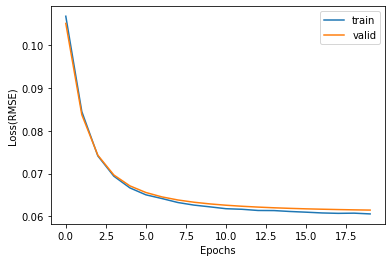

In [15]:
import matplotlib.pyplot as plt

plt.plot(records['train'], label='train')
plt.plot(records['valid'], label='valid')
plt.legend()
plt.ylabel('Loss(RMSE)')
plt.xlabel('Epochs')

## testing
calculate the RMSE of ratings

In [16]:
testLosses = []
for batch in testSet:
    mask = tf.cast(batch != -1, dtype=tf.float32)
    # replace unrated value with mean of ratings 
    mean = tf.reduce_sum(batch * mask, axis=-1, keepdims=True) / tf.reduce_sum(mask, axis=-1, keepdims=True)
    x = mask * batch + (1 - mask) * mean
    embedding = encoder.predict(x)
    pred = decoder.predict(embedding)
    testLoss = getLoss(pred=pred, gt=x, mask=mask)
    testLosses.append(testLoss)
print(f'RMSE: {tf.reduce_mean(testLosses)}')

RMSE: 0.06309384107589722
